In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
!pip install torch transformers datasets accelerate peft bitsandbytes trl


   ---------------------------------------- 0.0/113.8 MB ? eta -:--:--
    --------------------------------------- 2.1/113.8 MB 10.5 MB/s eta 0:00:11
   - -------------------------------------- 4.5/113.8 MB 11.5 MB/s eta 0:00:10
   -- ------------------------------------- 6.8/113.8 MB 10.7 MB/s eta 0:00:11
   --- ------------------------------------ 9.2/113.8 MB 10.7 MB/s eta 0:00:10
   --- ------------------------------------ 11.3/113.8 MB 10.8 MB/s eta 0:00:10
   ---- ----------------------------------- 13.9/113.8 MB 10.9 MB/s eta 0:00:10
   ----- ---------------------------------- 16.0/113.8 MB 10.8 MB/s eta 0:00:10
   ------ --------------------------------- 17.6/113.8 MB 10.3 MB/s eta 0:00:10
   ------ --------------------------------- 18.4/113.8 MB 9.7 MB/s eta 0:00:10
   ------ --------------------------------- 18.9/113.8 MB 9.0 MB/s eta 0:00:11
   ------- -------------------------------- 19.9/113.8 MB 8.6 MB/s eta 0:00:11
   ------- -------------------------------- 20.7/113.8 M

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.45.1 requires packaging<25,>=20, but you have packaging 25.0 which is incompatible.


   ----- ----------------------------------  2/16 [pyarrow]
   ----- ----------------------------------  2/16 [pyarrow]
   ----- ----------------------------------  2/16 [pyarrow]
   ----- ----------------------------------  2/16 [pyarrow]
   ----- ----------------------------------  2/16 [pyarrow]
   ----- ----------------------------------  2/16 [pyarrow]
   ----- ----------------------------------  2/16 [pyarrow]
   ----- ----------------------------------  2/16 [pyarrow]
   ----- ----------------------------------  2/16 [pyarrow]
   ----- ----------------------------------  2/16 [pyarrow]
   ----- ----------------------------------  2/16 [pyarrow]
   ----- ----------------------------------  2/16 [pyarrow]
   ----- ----------------------------------  2/16 [pyarrow]
   ----- ----------------------------------  2/16 [pyarrow]
   ----- ----------------------------------  2/16 [pyarrow]
   ----- ----------------------------------  2/16 [pyarrow]
   ----- -------------------------------

In [2]:
df = pd.read_csv(r"C:\Users\ASUS\OneDrive\Desktop\EXEMPTED\CODED\ML\T1\traffic flow\traffic.csv")

In [5]:
df['DateTime'] = pd.to_datetime(df['DateTime'])  # convert DateTime column into datetime format
df = df.sort_values('DateTime')            # sort data in time order

In [6]:
traffic_values = df['Vehicles'].values     # extract vehicle counts as numpy array


In [7]:
import numpy as np

def create_sequences(data, seq_len=24):
    X, y = [], []                              # store input and target sequences
    
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])             # input window
        y.append(data[i+1:i+seq_len+1])         # shifted target (next token prediction)

    return np.array(X), np.array(y)

X, y = create_sequences(traffic_values, seq_len=24)


In [8]:
import torch

X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # shape: (samples, seq_len, 1)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)


In [9]:
from torch.utils.data import Dataset

class TrafficDataset(Dataset):
    def __init__(self, X, y):
        self.X = X                              # store inputs
        self.y = y                              # store targets

    def __len__(self):
        return len(self.X)                       # dataset size

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]          # return sample pair


In [10]:
from torch.utils.data import DataLoader

dataset = TrafficDataset(X, y)                  
loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [12]:
import torch
import torch.nn as nn
import math

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


# TimeSeries LLM model
class TimeSeriesLLM(nn.Module):
    def __init__(self, input_dim=1, d_model=128, n_heads=8, num_layers=4):
        super().__init__()

        self.input_projection = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            batch_first=True
        )

        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

        self.output_layer = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.input_projection(x)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        return self.output_layer(x)



In [13]:
model = TimeSeriesLLM()                         # initialize LLM
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # optimizer
criterion = torch.nn.MSELoss()                  # regression loss


In [14]:
for epoch in range(20):                         # training epochs
    total_loss = 0

    for batch_x, batch_y in loader:             # iterate batches
        
        optimizer.zero_grad()                   # reset gradients
        
        output = model(batch_x)                 # forward pass through transformer
        
        loss = criterion(output, batch_y)       # compute prediction error
        
        loss.backward()                         # backpropagation
        
        optimizer.step()                        # update model weights
        
        total_loss += loss.item()

    print(f"Epoch {epoch}, Loss: {total_loss:.4f}")  # print epoch loss


Epoch 0, Loss: 532212.9022
Epoch 1, Loss: 493785.9138
Epoch 2, Loss: 489946.5750
Epoch 3, Loss: 489016.2546
Epoch 4, Loss: 488237.8418
Epoch 5, Loss: 487564.7997
Epoch 6, Loss: 486737.6503
Epoch 7, Loss: 488301.4202
Epoch 8, Loss: 488194.2980
Epoch 9, Loss: 486006.5465
Epoch 10, Loss: 485380.0523
Epoch 11, Loss: 485074.3646
Epoch 12, Loss: 485524.3829
Epoch 13, Loss: 484695.8313
Epoch 14, Loss: 484155.2533
Epoch 15, Loss: 483884.9037
Epoch 16, Loss: 485309.9809
Epoch 17, Loss: 484014.6371
Epoch 18, Loss: 483597.9139
Epoch 19, Loss: 484337.3139


In [15]:
model.eval()                                  # set model to evaluation mode

predictions = []
actuals = []

with torch.no_grad():                          # disable gradient calculation
    for batch_x, batch_y in loader:             # iterate through dataset
        
        output = model(batch_x)                 # model prediction
        
        predictions.append(output.numpy())      # store predictions
        actuals.append(batch_y.numpy())         # store actual values


In [16]:
import numpy as np

predictions = np.concatenate(predictions)      # merge all batches
actuals = np.concatenate(actuals)


In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(actuals.flatten(), predictions.flatten())
rmse = np.sqrt(mean_squared_error(actuals.flatten(), predictions.flatten()))

print("MAE:", mae)
print("RMSE:", rmse)


MAE: 14.019740104675293
RMSE: 18.089785970135537


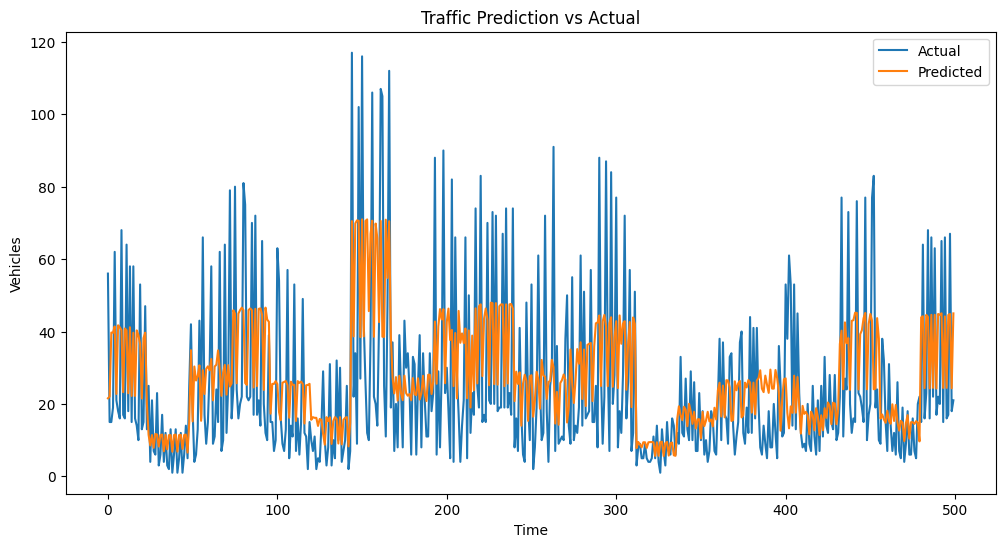

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))                      # figure size
plt.plot(actuals.flatten()[:500], label='Actual')      # first 500 points actual
plt.plot(predictions.flatten()[:500], label='Predicted')  # first 500 predicted
plt.legend()
plt.title("Traffic Prediction vs Actual")
plt.xlabel("Time")
plt.ylabel("Vehicles")
plt.show()
